In [1]:
# This script will analyse the vetting of all candidates. Then we will decide which threshold
# we will use during training and prediction.
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pylab as plt

figSize  = (16, 10)
fontSize = 20
%matplotlib inline

In [2]:
data_dir = '../data/'
fits_file = 'vetting_4Zafiirah_20200714102528.fits'

In [3]:
# Read fits file
table = Table.read(data_dir+fits_file)

In [4]:
# Convert fits file to pandas data frame
# removing the images from the data frame due to high dimensional data
names = [name for name in table.colnames if len(table[name].shape) <= 1]
print(names)
param_table = table[names].to_pandas()
param_table.head()

['transientid', 'username', 'vettingdate', 'vetclas', 'number', 'image', 'date-obs', 'filter', 'object', 't-ntrans', 'pc-zpstd', 'psf-fwhm', 's-seeing', 's-seestd', 'x_peak', 'y_peak', 'ra_peak', 'dec_peak', 'flux_peak', 'fluxerr_peak', 'mag_peak', 'magerr_peak']


,transientid,username,vettingdate,vetclas,number,image,date-obs,filter,object,t-ntrans,...,s-seeing,s-seestd,x_peak,y_peak,ra_peak,dec_peak,flux_peak,fluxerr_peak,mag_peak,magerr_peak
0,510,b'dpieterse',b'2020-05-08 00:06:45.492000',b'bogus',547,5,b'2017-09-01 17:36:00.000000',b'q',90005,170,...,2.601214,0.078431,9848,8471,233.559933,-13.202148,105.561905,7.361342,18.841297,0.075714
1,510,b'pmv',b'2020-05-08 00:09:02.602000',b'bogus',547,5,b'2017-09-01 17:36:00.000000',b'q',90005,170,...,2.601214,0.078431,9848,8471,233.559933,-13.202148,105.561905,7.361342,18.841297,0.075714
2,510,b'pgroot',b'2020-05-08 09:12:52.507000',b'bogus',547,5,b'2017-09-01 17:36:00.000000',b'q',90005,170,...,2.601214,0.078431,9848,8471,233.559933,-13.202148,105.561905,7.361342,18.841297,0.075714
3,510,b'simon',b'2020-05-08 09:20:26.132000',b'bogus',547,5,b'2017-09-01 17:36:00.000000',b'q',90005,170,...,2.601214,0.078431,9848,8471,233.559933,-13.202148,105.561905,7.361342,18.841297,0.075714
4,510,b'nblago',b'2020-05-08 10:33:52.220000',b'bogus',547,5,b'2017-09-01 17:36:00.000000',b'q',90005,170,...,2.601214,0.078431,9848,8471,233.559933,-13.202148,105.561905,7.361342,18.841297,0.075714


In [5]:
#param_table.to_csv('params_table.csv',index=None)

In [5]:
param_table.username.unique()

array([b'dpieterse', b'pmv', b'pgroot', b'simon', b'nblago', b'jkersten',
       b'sbloemen', b'naomi', b'AstroLauraD', b'zafiirah', b'dmodiano',
       b'mbeijer', b'rruizc'], dtype=object)

In [6]:
print("The number of sources in dataset {}".format(len(np.unique(param_table.transientid))))

The number of sources in dataset 5000


In [7]:
table1 = param_table
transientids = table1.transientid.unique()
final_table  = pd.DataFrame()
print(transientids.shape)

for ids in transientids:
    source   = table1[table1.transientid==ids]    
    matching_bogus = [b for b in source['vetclas'].values if b"bogus" in b]
    matching_real  = [r for r in source['vetclas'].values if b"real" in r]
    make_table = pd.DataFrame([ids],columns=['transientid'])
    make_table['bogus'] = len(matching_bogus)
    make_table['real']  = len(matching_real)
    #print(len(matching_bogus),len(matching_real))
    for i in range(5,11):
        if len(matching_bogus) >= i:
            make_table['label_'+str(i)] = 0
        elif len(matching_real) >= i:
            make_table['label_'+str(i)] = 1
        else:
            make_table['label_'+str(i)] = None
                    
    final_table         = final_table.append(make_table,ignore_index=True)
print(final_table.shape)

(5000,)
(5000, 9)


In [8]:
final_table.head()

,transientid,bogus,real,label_5,label_6,label_7,label_8,label_9,label_10
0,510,10,0,0,0,0,0,0,0
1,607,9,1,0,0,0,0,0,None
2,707,10,0,0,0,0,0,0,0
3,725,10,0,0,0,0,0,0,0
4,5233,0,10,1,1,1,1,1,1


In [9]:
final_table.to_csv('../data/voting_5000.csv',index=None)

In [10]:
final_table = pd.read_csv('../data/voting_5000.csv')

In [11]:
n_real  = []
n_bogus = []
num_people = np.arange(5,11)
for j in range(5,11):
    num_real  = final_table[final_table['label_'+str(j)] == 1].shape[0]
    num_bogus = final_table[final_table['label_'+str(j)] == 0].shape[0]
    n_real.append(num_real)
    n_bogus.append(num_bogus)
    
print(str(num_people))

[ 5  6  7  8  9 10]


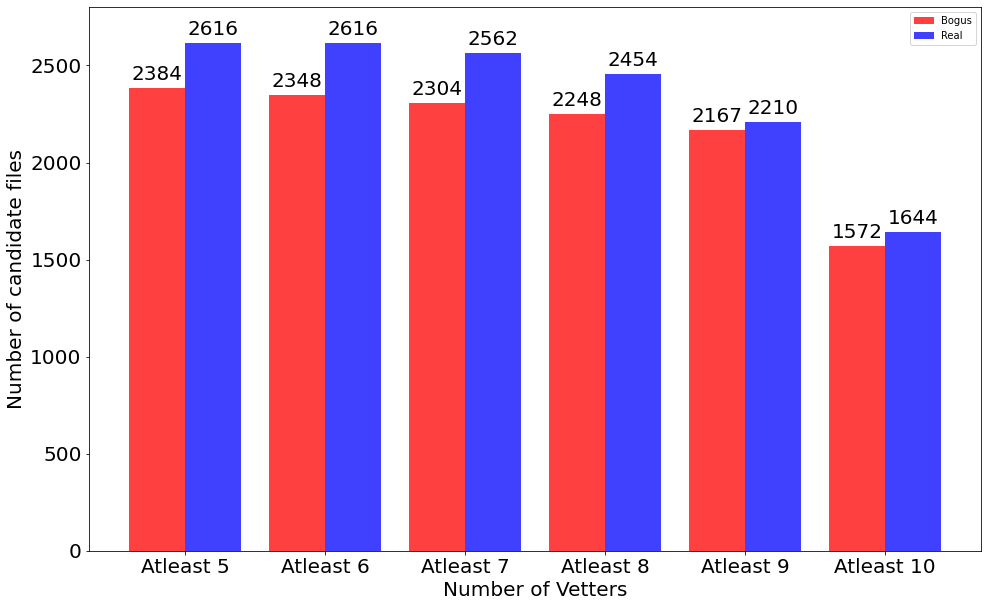

In [12]:
labels     = ['Atleast 5','Atleast 6', 'Atleast 7', 'Atleast 8', 'Atleast 9', 'Atleast 10']
bar_width = 0.4
opacity   = 0.75
plt.figure(figsize = figSize)


def top(rects):
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 4
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,fontsize=fontSize)                      # Vertically align label differently for
                                        # positive and negative values.

ax = plt.bar(np.arange(6),n_bogus, bar_width, alpha = opacity, label = 'Bogus', color = 'r')
top(ax.patches)
ax = plt.bar(np.arange(6)+bar_width,n_real, bar_width, alpha = opacity, label = 'Real', color = 'b')
top(ax.patches)
plt.ylabel('Number of candidate files', fontsize = fontSize)
plt.xlabel('Number of Vetters', fontsize = fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.xticks(np.arange(6)+bar_width/2, labels)
plt.ylim(0,2800)
plt.legend(loc = 'best')
#plt.savefig('Consistency_in_labelling_5000.pdf', bbox_inches='tight', pad_inches=0.1)

# rects = ax.patches


plt.show()